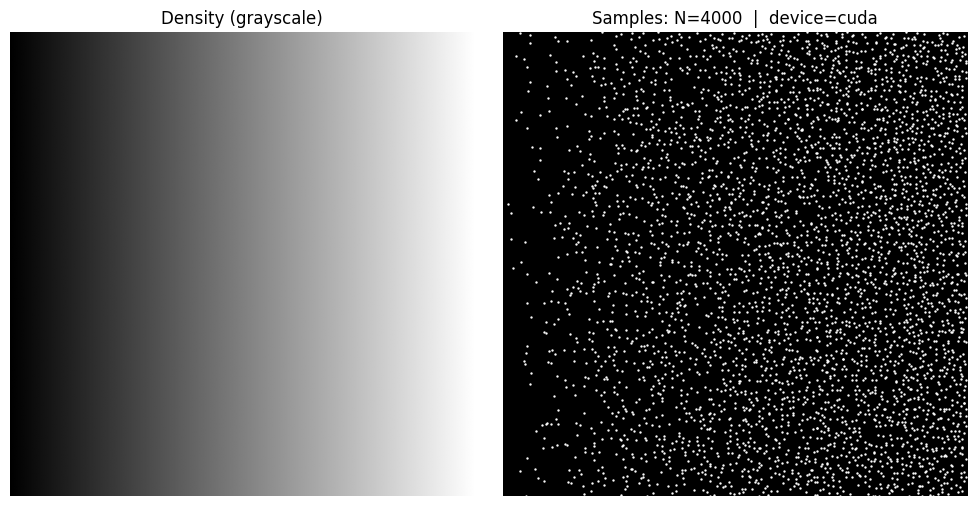

In [2]:
# High-performance, GPU-parallel, density-controlled blue-noise sampling
# =============================================================================
# Academic-quality, readable, single-cell implementation for Colab/PyTorch.
#
# Key ideas
# ---------
# • You provide ANY density as a Python lambda:  rho(u, v) on [0,1]×[0,1].
# • We generate a quasi-blue-noise *uniform* set via stratified jittered grid (fully vectorized).
# • We then **select** a subset of points *according to your density* using the Gumbel-Top-K trick
#   (parallel, without replacement), which preserves good spacing from the stratified pool.
# • No O(N^2) loops, no per-point neighbor scans. Everything is batched and GPU-friendly.
#
# What you get
# ------------
# • `sample_blue_noise_density(...)` returns integer pixel coords (n_points×2) aligned to `res×res`.
# • Side-by-side plot: grayscale ramp image (your density) and the sampled points.
#
# Notes
# -----
# • For “ramp” densities (linear, vertical, radial, etc.), just pass a lambda. Examples below.
# • If later you require stricter minimal-distance enforcement, add a single grid-based culling pass;
#   the current method already provides very good spacing for training data due to stratification.

import math
import torch
import matplotlib.pyplot as plt

# ---------------------------
# Utilities & core primitives
# ---------------------------

def _pick_device(device: str | None = None) -> str:
    """Pick CUDA if available unless explicitly requested otherwise."""
    if device is not None:
        return device
    return "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def _make_jittered_grid(n_points: int, oversample: float, device: str) -> torch.Tensor:
    """
    Stratified jittered grid in [0,1]^2.
    Generates M = ceil(n_points * oversample) points, then shuffles.

    Returns: (M, 2) tensor on `device`, coordinates in [0,1].
    """
    M = int(math.ceil(n_points * max(1.0, oversample)))
    G = int(math.ceil(math.sqrt(M)))             # grid resolution
    ix = torch.arange(G, device=device, dtype=torch.float32)
    iy = torch.arange(G, device=device, dtype=torch.float32)
    X, Y = torch.meshgrid(ix, iy, indexing="xy") # (G,G)

    # Stratified: one random jitter per cell
    jitter = torch.rand((G, G, 2), device=device)
    pts = (torch.stack([X, Y], dim=-1) + jitter) / G   # (G,G,2) → in [0,1]
    pts = pts.view(-1, 2)                               # (G*G, 2)

    # Random shuffle and truncate to M
    idx = torch.randperm(pts.shape[0], device=device)[:M]
    return pts[idx]

@torch.no_grad()
def _eval_density_on_grid(res: int, density_fn, device: str) -> torch.Tensor:
    """
    Evaluate a user-supplied density function ρ(u,v) over a res×res grid on [0,1]^2.

    density_fn must accept tensors U,V (broadcastable) and return nonnegative values.
    Returns: ρ as (res,res) tensor on `device`, normalized to sum=1 (with epsilon for safety).
    """
    # Grid of normalized coordinates
    xs = torch.linspace(0.0, 1.0, res, device=device)
    ys = torch.linspace(0.0, 1.0, res, device=device)
    U, V = torch.meshgrid(xs, ys, indexing="xy")

    rho = density_fn(U, V)
    rho = torch.clamp(rho, min=0.0)
    s = rho.sum()
    rho = rho / (s + 1e-12)
    return rho

@torch.no_grad()
def _eval_density_on_points(pts_uv: torch.Tensor, density_fn) -> torch.Tensor:
    """
    Evaluate ρ(u,v) for a (N,2) tensor of points in [0,1]^2.

    Returns: (N,) nonnegative, normalized weights (sum=1).
    """
    u, v = pts_uv[:, 0], pts_uv[:, 1]
    w = density_fn(u, v)
    w = torch.clamp(w, min=0.0)
    w_sum = w.sum()
    w = w / (w_sum + 1e-12)
    return w

@torch.no_grad()
def _gumbel_topk_sample_without_replacement(weights: torch.Tensor, k: int) -> torch.Tensor:
    """
    Parallel sampling w/out replacement using Gumbel-Top-K.
    We sample top-k indices according to 'weights' (already nonnegative, not all zero).

    Returns: (k,) indices (dtype long).
    """
    # logw + Gumbel noise → top-k
    logw = torch.log(weights + 1e-20)
    g = -torch.log(-torch.log(torch.rand_like(logw) + 1e-20) + 1e-20)
    scores = logw + g
    return torch.topk(scores, k=k, largest=True).indices

# ---------------------------
# Main public API
# ---------------------------

@torch.no_grad()
def sample_blue_noise_density(
    res: int = 512,
    n_points: int = 3000,
    density_fn = None,            # required: lambda U,V → ρ(U,V) on [0,1]^2
    oversample: float = 2.0,       # >1 gives a richer stratified pool to select from
    device: str | None = None,
    seed: int | None = None,
    plot: bool = True
):
    """
    High-performance, GPU-parallel sampling of n_points distributed according to ρ(u,v),
    while preserving good spacing via stratified jittered grid + Gumbel-Top-K selection.

    Parameters
    ----------
    res : int
        Output resolution (res×res). Used for ramp image and for final integer coordinates.
    n_points : int
        Number of points to return.
    density_fn : callable
        User-provided lambda ρ(U,V) mapping [0,1]^2 → nonnegative densities (tensor-friendly).
        Must support torch tensors, e.g.:
            rho_linear_x = lambda U,V: U
            rho_vertical = lambda U,V: V**2
            rho_radial   = lambda U,V: (1.0 - torch.sqrt((U-0.5)**2 + (V-0.5)**2)/0.7071).clamp(min=0.0)
    oversample : float
        Factor for stratified pool size (M ≈ n_points * oversample). Higher → better spacing fidelity.
    device : str | None
        "cuda" or "cpu"; if None, auto-selects CUDA if available.
    seed : int | None
        RNG seed for reproducibility.
    plot : bool
        If True, render side-by-side: density (grayscale) and sampled points.

    Returns
    -------
    coords : torch.IntTensor (n_points, 2) on CPU
        Integer pixel coordinates (x,y) in [0, res-1].
    """
    assert callable(density_fn), "Please provide a density_fn: lambda U,V → rho(U,V)."

    device = _pick_device(device)
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manual_seed_all(seed)

    # 1) Evaluate the density on a grid (for visualization) and normalize.
    rho_grid = _eval_density_on_grid(res, density_fn, device=device)  # (res,res), sum=1

    # 2) Build a stratified candidate pool (quasi-blue-noise uniform in [0,1]^2).
    pool_uv = _make_jittered_grid(n_points=n_points, oversample=oversample, device=device)  # (M,2)

    # 3) Compute normalized weights at pool samples according to the density.
    w = _eval_density_on_points(pool_uv, density_fn)  # (M,), sum=1

    # 4) Parallel sampling without replacement: pick exactly n_points by weight.
    sel_idx = _gumbel_topk_sample_without_replacement(w, k=n_points)  # (n_points,)
    pts_uv = pool_uv[sel_idx]  # (n_points,2) in [0,1]

    # 5) Convert to integer pixel coordinates in [0,res-1].
    coords = (pts_uv * res).clamp(0, res - 1 - 1e-6).floor().to(torch.int32).to("cpu")  # (n_points,2)

    # 6) Optional side-by-side plot: grayscale density + sampled points
    if plot:
        # Density image (grayscale)
        rho_img = rho_grid.detach().cpu()
        rho_img = (rho_img / (rho_img.max() + 1e-12)).float()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Left: density function
        axes[0].imshow(rho_img.numpy(), cmap="gray", origin="upper", vmin=0.0, vmax=1.0)
        axes[0].set_title("Density (grayscale)")
        axes[0].axis("off")

        # Right: sampled points (scatter)
        axes[1].imshow(torch.ones((res, res)), cmap="gray", origin="upper")
        axes[1].scatter(coords[:,0], coords[:,1], s=2, c="white", marker=".")
        axes[1].set_title(f"Samples: N={n_points}  |  device={device}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()


    return coords

# ---------------------------------
# Example usage (edit/replace below)
# ---------------------------------
if __name__ == "__main__":
    # EXAMPLE 1: Linear ramp (left→right denser)
    rho_linear_x = lambda U, V: U

    # EXAMPLE 2: Vertical quadratic ramp (top→bottom, stronger at bottom)
    rho_vertical_quad = lambda U, V: V**2

    # EXAMPLE 3: Radial center-dense (smooth, zero at corners, one near center)
    # 0.7071 ≈ max distance from center to a square corner in unit square (sqrt(2)/2)
    rho_radial = lambda U, V: (1.0 - torch.sqrt((U-0.5)**2 + (V-0.5)**2) / 0.7071).clamp(min=0.0)

    _ = sample_blue_noise_density(
        res=512,
        n_points=4000,
        density_fn=rho_linear_x,   # swap in any lambda above (or your own)
        # density_fn=rho_radial,   # swap in any lambda above (or your own)
        oversample=2.0,
        device=None,               # auto: CUDA if available
        seed=1234,
        plot=True
    )


In [3]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def cc_lloyd_relaxation_wrapper(
    base_sampler,
    density_fn,
    res=512,
    n_points=3000,
    iters=5,
    device=None,
    seed=None,
    plot=True
):
    """
    Wraps an existing blue-noise sampler with capacity-constrained Lloyd relaxation.

    Parameters
    ----------
    base_sampler : callable
        Your existing sampler function (e.g. sample_blue_noise_density).
        Must return (n_points, 2) float/int coordinates in [0,res).
    density_fn : callable
        Density function rho(U,V) on [0,1]^2.
    res : int
        Domain resolution for both sampling and Lloyd grid.
    n_points : int
        Number of points.
    iters : int
        Number of CC Lloyd iterations.
    device : str or None
        "cuda" or "cpu"; auto-selects CUDA if available.
    seed : int or None
        RNG seed.
    plot : bool
        If True, show before/after scatter side-by-side.

    Returns
    -------
    coords_relaxed : torch.Tensor
        (n_points,2) final relaxed coordinates on CPU.
    """
    device = "cuda" if (device is None and torch.cuda.is_available()) else "cpu"
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manual_seed_all(seed)

    # 1. Generate initial samples with base sampler
    coords0 = base_sampler(res=res, n_points=n_points,
                           density_fn=density_fn, device=device,
                           seed=seed, plot=False).float().to(device)

    coords = coords0.clone()

    # 2. Build discrete grid for CC Lloyd iterations
    xs = torch.linspace(0, 1, res, device=device)
    ys = torch.linspace(0, 1, res, device=device)
    U, V = torch.meshgrid(xs, ys, indexing="xy")
    rho = density_fn(U, V).clamp(min=0.0)
    rho = rho / (rho.sum() + 1e-12)  # normalize weights
    rho = rho.unsqueeze(-1)  # (res,res,1)

    grid = torch.stack([U*res, V*res], dim=-1)  # (res,res,2) pixel centers

    # 3. CC Lloyd iterations
    for _ in range(iters):
        # Compute nearest site for each pixel
        d2 = torch.cdist(grid.view(-1,2), coords)  # (res*res, n_points)
        assign = d2.argmin(dim=1)                  # nearest site index per pixel

        # Weighted centroids
        rho_flat = rho.view(-1)                    # weights per pixel
        num = torch.zeros((n_points,2), device=device)
        den = torch.zeros((n_points,), device=device)

        num.index_add_(0, assign, grid.view(-1,2) * rho_flat[:,None])
        den.index_add_(0, assign, rho_flat)

        coords = num / (den[:,None] + 1e-12)

    # rescale to 512×512 output
    coords_relaxed = torch.zeros((n_points, 2), device=device)
    if res != 512:
        # coords_relaxed = torch.zeros((n_points, 2), device=device)
        coords_relaxed = (coords_relaxed / res * 512).clamp(0, 511).to(torch.int32)

    coords_relaxed = coords.to("cpu")

    # 4. Plot before vs after
    if plot:
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].scatter(coords0[:,0].cpu(), coords0[:,1].cpu(),
                        s=2, c="black")
        axes[0].set_title("Initial samples")
        axes[0].set_xlim(0,res); axes[0].set_ylim(res,0); axes[0].axis("off")

        axes[1].scatter(coords_relaxed[:,0], coords_relaxed[:,1],
                        s=2, c="black")
        axes[1].set_title(f"CC Lloyd-relaxed ({iters} iters)")
        axes[1].set_xlim(0,res); axes[1].set_ylim(res,0); axes[1].axis("off")
        plt.tight_layout(); plt.show()

    return coords_relaxed


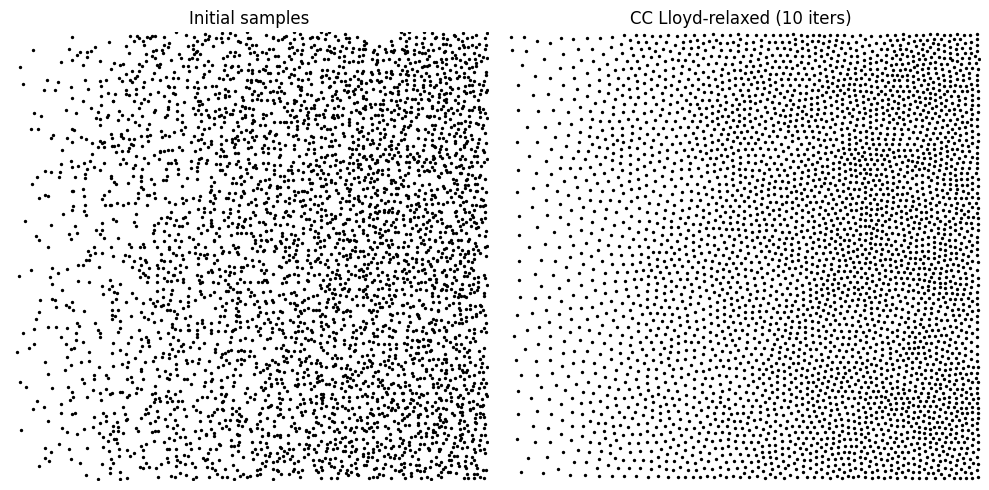

Final relaxed coords shape: torch.Size([4000, 2])


In [4]:
# Example usage of CC Lloyd wrapper
if __name__ == "__main__":
    # Define a ramp density function (example: linear ramp left→right)
    rho_linear = lambda U, V: U

    # Run the wrapper
    coords_relaxed = cc_lloyd_relaxation_wrapper(
        base_sampler=sample_blue_noise_density,  # your existing sampler
        density_fn=rho_linear,
        res=512,          # domain resolution (keep lower for speed in Lloyd)
        n_points=4000,    # number of points
        iters=10,          # CC Lloyd iterations
        device=None,      # auto: CUDA if available
        seed=12345,
        plot=True         # show before/after
    )

    print("Final relaxed coords shape:", coords_relaxed.shape)


In [5]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def cc_lloyd_multires_wrapper(
    base_sampler,
    density_fn,
    n_points=3000,
    out_res=512,
    iters_per_level=(2,1),  # (coarse_iters, fine_iters)
    levels=(128, 512),      # grid resolutions to use progressively
    device=None,
    seed=None,
    plot=True
):
    """
    Multi-resolution capacity-constrained Lloyd relaxation (discretized).
    Starts from base_sampler, refines sites on coarse then fine grids.

    Parameters
    ----------
    base_sampler : callable
        Your existing sampler, e.g. sample_blue_noise_density.
    density_fn : callable
        Density function rho(U,V) on [0,1]^2.
    n_points : int
        Number of points.
    out_res : int
        Output resolution (final coordinates scaled to this).
    iters_per_level : tuple(int,int)
        Number of Lloyd iterations at each level.
    levels : tuple(int,int)
        Grid resolutions (coarse → fine).
    device : str or None
        "cuda" or "cpu"; auto-selects CUDA if available.
    seed : int or None
        RNG seed.
    plot : bool
        If True, scatter before/after.

    Returns
    -------
    coords_relaxed : (n_points,2) tensor on CPU
    """
    device = "cuda" if (device is None and torch.cuda.is_available()) else "cpu"
    if seed is not None:
        torch.manual_seed(seed)
        if device == "cuda":
            torch.cuda.manual_seed_all(seed)

    # Initial points
    coords0 = base_sampler(res=out_res, n_points=n_points,
                           density_fn=density_fn, device=device,
                           seed=seed, plot=False).float().to(device)
    coords = coords0.clone()

    # Progressive Lloyd iterations
    for level_res, n_iter in zip(levels, iters_per_level):
        # Precompute density and pixel grid at this resolution
        xs = torch.linspace(0, 1, level_res, device=device)
        ys = torch.linspace(0, 1, level_res, device=device)
        U, V = torch.meshgrid(xs, ys, indexing="xy")
        rho = density_fn(U, V).clamp(min=0.0)
        rho = rho / (rho.sum() + 1e-12)
        rho_flat = rho.view(-1)
        pixels = torch.stack([U*level_res, V*level_res], dim=-1).view(-1,2)  # (M,2)

        for _ in range(n_iter):
            # Assign pixels to nearest site
            d2 = torch.cdist(pixels, coords)     # (M,n_points)
            assign = d2.argmin(dim=1)            # nearest site idx

            # Weighted centroids
            num = torch.zeros((n_points,2), device=device)
            den = torch.zeros((n_points,), device=device)
            num.index_add_(0, assign, pixels * rho_flat[:,None])
            den.index_add_(0, assign, rho_flat)
            coords = num / (den[:,None] + 1e-12)

    # Scale to output resolution
    coords_relaxed = (coords / levels[-1] * out_res).clamp(0, out_res-1).to("cpu")

    if plot:
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].scatter(coords0[:,0].cpu(), coords0[:,1].cpu(), s=2, c="black")
        axes[0].set_title("Initial samples")
        axes[0].set_xlim(0,out_res); axes[0].set_ylim(out_res,0); axes[0].axis("off")
        axes[1].scatter(coords_relaxed[:,0], coords_relaxed[:,1], s=2, c="black")
        axes[1].set_title(f"CC Lloyd relaxed ({iters_per_level} iters)")
        axes[1].set_xlim(0,out_res); axes[1].set_ylim(out_res,0); axes[1].axis("off")
        plt.tight_layout(); plt.show()

    return coords_relaxed


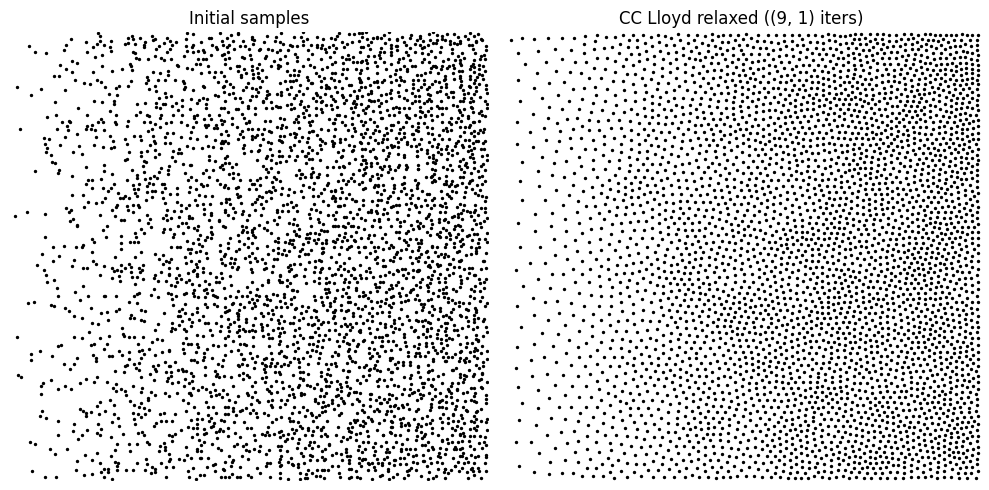

Final relaxed coords shape: torch.Size([4000, 2])


In [6]:
# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # Example density: linear ramp left→right
    rho_linear = lambda U, V: U

    # Run the multi-resolution CC Lloyd wrapper
    coords_relaxed = cc_lloyd_multires_wrapper(
        base_sampler=sample_blue_noise_density,  # <- your existing sampler
        density_fn=rho_linear,
        n_points=4000,
        out_res=512,
        iters_per_level=(9, 1),  # 2 iterations on coarse grid, 1 on fine grid
        levels=(512, 512),       # first 128² grid, then refine at 512²
        device=None,             # auto-select CUDA if available
        seed=42,
        plot=True                # show before/after scatter
    )

    print("Final relaxed coords shape:", coords_relaxed.shape)


In [7]:
print(coords_relaxed)


tensor([[292.2705, 128.4369],
        [394.8038, 148.6240],
        [167.4203,  11.5883],
        ...,
        [ 68.4817, 147.2579],
        [188.3584, 351.1216],
        [502.9679, 240.9703]])


In [ ]:
!pip install -q diffusers transformers accelerate safetensors controlnet_aux

In [18]:
!pip install git+https://github.com/facebookresearch/xformers.git

  Cloning https://github.com/facebookresearch/xformers.git to /tmp/pip-req-build-symkrk5n
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/xformers.git /tmp/pip-req-build-symkrk5n
  Resolved https://github.com/facebookresearch/xformers.git to commit c159edc05ae5a0192ab0558e834b946155790371
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xformers: filename=xformers-0.0.33+c159edc.d20250902-cp39-abi3-linux_x86_64.whl size=6346768 sha256=e238318389cdacf24348184d0c197611cc83377a00ab23153f9a16d59c178bb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-l_1uw1te/wheels/d4/35/fe/555c75d35b2c79cd9399ae6b577c3cdec15caec2f5011e2ee1
Successfully built xformers


In [24]:
import xformers
xformers.__version__

'0.0.33+c159edc.d20250902'

In [19]:
torch.cuda.is_available()

True

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.06it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|██████████| 30/30 [00:01<00:00, 19.69it/s]


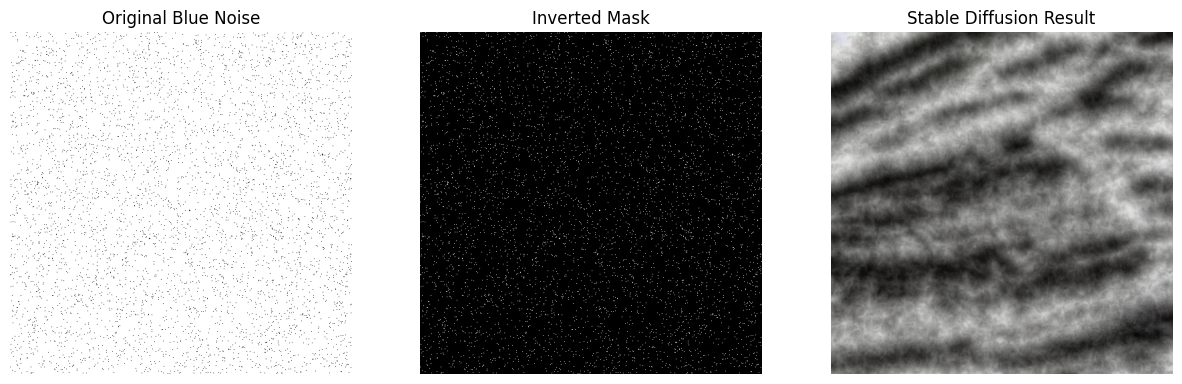

In [ ]:
# =============================================
# Colab: Blue-noise → Inversion → SD 1.5 + ControlNet
# =============================================

import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# ------------------------------------------------------
# 1. Load ControlNet (Canny) + Stable Diffusion v1.5
# ------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

# pipe.enable_xformers_memory_efficient_attention()

# ------------------------------------------------------
# 2. Load your blue-noise mask (replace with your own)
# ------------------------------------------------------
# Example: generate dummy blue-noise as random dots (replace with your 512x512 image)
res = 512
blue_noise = np.ones((res, res), dtype=np.float32) * 255
yy, xx = np.random.randint(0,res,5000), np.random.randint(0,res,5000)
blue_noise[yy,xx] = 0

img = Image.fromarray(blue_noise.astype(np.uint8)).convert("RGB")

# Invert the mask
img_inverted = Image.fromarray(255 - blue_noise.astype(np.uint8)).convert("RGB")

# ------------------------------------------------------
# 3. Run SD 1.5 with ControlNet using the inverted mask
# ------------------------------------------------------
# prompt = "highly detailed organic texture, cinematic lighting"
prompt = ""

result = pipe(
    prompt=prompt,
    image=img_inverted,
    num_inference_steps=30,
    guidance_scale=7.5
).images[0]

# ------------------------------------------------------
# 4. Plot input vs inverted vs generated result
# ------------------------------------------------------
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(img); axes[0].set_title("Original Blue Noise"); axes[0].axis("off")
axes[1].imshow(img_inverted); axes[1].set_title("Inverted Mask"); axes[1].axis("off")
axes[2].imshow(result); axes[2].set_title("Stable Diffusion Result"); axes[2].axis("off")
plt.show()
